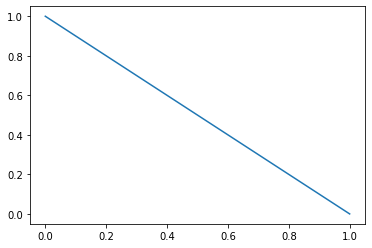

In [1]:
import matplotlib
%matplotlib inline  
#matplotlib.use('')
import matplotlib.pyplot as plt
plt.plot([0,1],[1,0])
plt.show()
import matplotlib
import numpy as np
#import matplotlib.pyplot as plt
import sciunit.utils as utils
from sciunit.utils import redirect_stdout

#utils.redirect_stdout()

In [2]:
import collections
import copy
# Fast spiking cannot be reproduced as it requires modifications to the standard Izhi equation,
# which are expressed in this mod file.
# https://github.com/OpenSourceBrain/IzhikevichModel/blob/master/NEURON/izhi2007b.mod

from collections import OrderedDict
type2007 = collections.OrderedDict([
  #              C    k     vr  vt vpeak   a      b   c    d  celltype
  ('RS',        (100, 0.7,  -60, -40, 35, 0.03,   -2, -50,  100,  1)),
  ('IB',        (150, 1.2,  -75, -45, 50, 0.01,   5, -56,  130,   2)),
  ('CH',        (50,  1.5,  -60, -40, 25, 0.03,   1, -40,  150,   3)),
  ('LTS',       (100, 1.0,  -56, -42, 40, 0.03,   8, -53,   20,   4)),
  ('FS',        (20,  1.0,  -55, -40, 25, 0.2,   -2, -45,  -55,   5)),
  ('TC',        (200, 1.6,  -60, -50, 35, 0.01,  15, -60,   10,   6)),
  ('TC_burst',  (200, 1.6,  -60, -50, 35, 0.01,  15, -60,   10,   6)),
  ('RTN',       (40,  0.25, -65, -45,  0, 0.015, 10, -55,   50,   7)),
  ('RTN_burst', (40,  0.25, -65, -45,  0, 0.015, 10, -55,   50,   7))])

import numpy as np
param_dict = OrderedDict([(k,[]) for k in ['C','k','vr','vt','vPeak','a','b','c','d']])
#OrderedDict
for i,k in enumerate(param_dict.keys()):
    for v in type2007.values():
        param_dict[k].append(v[i])

explore_param = {k:(np.min(v),np.max(v)) for k,v in param_dict.items()}
param_ranges = OrderedDict(explore_param)


#IB = mparams[param_dict['IB']]
IB = {}
TC = {}
CH = {}
RTN_burst = {}
for k,v in param_dict.items():
    IB[k] = v[1]
    CH[k] = v[2]
    TC[k] = v[5]
    RTN_burst[k] = v[-2]
    
RTN_burstN_= copy.copy(RTN_burst)
TCN_ = copy.copy(TC)
IBN_ = copy.copy(IB)
CHN_ = copy.copy(CH)


# From OSB models
mparams = {}
mparams['a'] = 0.03
mparams['b'] = -2
mparams['C'] = 100
mparams['c'] = -50 
mparams['vr'] = -60
mparams['vt'] = -40
mparams['vpeak'] = 35
mparams['k'] = 0.7
mparams['d'] = 100


# FROM the MOD file.
vanilla_NRN = {}
#vanilla_NRN['v0'] = -60# (mV)
vanilla_NRN['k'] = 7.0E-4# (uS / mV)
vanilla_NRN['vr'] = -60# (mV)
vanilla_NRN['vt'] = -40# (mV)
vanilla_NRN['vpeak'] = 35# (mV)
vanilla_NRN['a'] = 0.03# (kHz)
vanilla_NRN['b'] = -0.002# (uS)
vanilla_NRN['c'] = -50# (mV)
vanilla_NRN['d'] = 0.1# (nA)
vanilla_NRN['C'] = 1.0E-4# (microfarads)

m2m = {}

for k,v in vanilla_NRN.items():
    m2m[k] = vanilla_NRN[k]/mparams[k]


def translate(input_dic,m2m):
    input_dic['vpeak'] = input_dic['vPeak']
    input_dic.pop('vPeak', None)     
    input_dic.pop('dt', None)        
    for k,v in input_dic.items():
        input_dic[k] = v * m2m[k]
    return input_dic
IBN = translate(IBN_,m2m)
RTN_burstN = translate(RTN_burstN_,m2m)
CHN = translate(CHN_,m2m)
TCN = translate(TCN_,m2m)
print(CH)
print(CHN)
print(IB)
print(IBN)
print(TC)
print(TCN)

{'C': 50, 'k': 1.5, 'vr': -60, 'vt': -40, 'vPeak': 25, 'a': 0.03, 'b': 1, 'c': -40, 'd': 150}
{'C': 4.9999999999999996e-05, 'k': 0.0015, 'vr': -60.0, 'vt': -40.0, 'a': 0.03, 'b': 0.001, 'c': -40.0, 'd': 0.15, 'vpeak': 25.0}
{'C': 150, 'k': 1.2, 'vr': -75, 'vt': -45, 'vPeak': 50, 'a': 0.01, 'b': 5, 'c': -56, 'd': 130}
{'C': 0.00015, 'k': 0.0012, 'vr': -75.0, 'vt': -45.0, 'a': 0.01, 'b': 0.005, 'c': -56.0, 'd': 0.13, 'vpeak': 50.0}
{'C': 200, 'k': 1.6, 'vr': -60, 'vt': -50, 'vPeak': 35, 'a': 0.01, 'b': 15, 'c': -60, 'd': 10}
{'C': 0.00019999999999999998, 'k': 0.0016, 'vr': -60.0, 'vt': -50.0, 'a': 0.01, 'b': 0.015, 'c': -60.0, 'd': 0.01, 'vpeak': 35.0}


In [3]:
import numpy as np
import time

import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuronunit.models import ReducedModel

from neuronunit.models.very_reduced_sans_lems import VeryReducedModel
from neuronunit.optimisation.model_parameters import path_params
from neuronunit.optimisation import model_parameters as modelp

#from neuronunit.optimization.model_parameters import model_params, path_params
LEMS_MODEL_PATH = path_params['model_path']
#import neuronunit.optimization as opt
import quantities as pq

consider installing pynn a heavier backend


INFO       Cache size for target "cython": 1084 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/russell/.cython/brian_extensions" directory. [brian2]


pynn python Error
could not import brian2 neuronaldynamicsError


In [ ]:
from neuronunit.optimisation import get_neab
tests = get_neab.process_all_cells()

{'injected_square_current': {'amplitude': array(-10.) * pA, 'delay': array(200.) * ms, 'duration': array(500.) * ms}}
0.00015
0.00015
0.00015
0.00015
0.00015


WARNING    /usr/local/lib/python3.6/dist-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 [py.warnings]
  out=out, **kwargs)

WARNING    /usr/local/lib/python3.6/dist-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]
  ret = ret.dtype.type(ret / rcount)

WARNING    /usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:39: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
 [py.warnings]



mean simulation time: nan. Total time: 0.0
{'Olfactory bulb (main) mitral cell': <sciunit.suites.TestSuite object at 0x7f6853b5a400>, 'Hippocampus CA1 pyramidal cell': <sciunit.suites.TestSuite object at 0x7f6853b5a4a8>, 'Cerebellum Purkinje cell': <sciunit.suites.TestSuite object at 0x7f6853b5af28>, 'Neocortex pyramidal cell layer 5-6': <sciunit.suites.TestSuite object at 0x7f6853b6c1d0>}


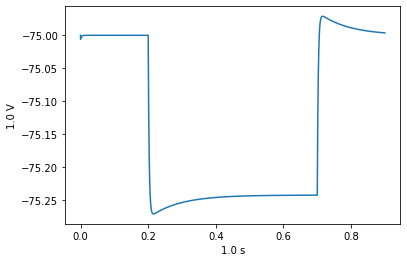

In [4]:

import time
times = []
times_without_init = []

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
waves0 = []
#model.set_attrs(mparams)

#for current in [60,70,85,100]:
iparams = {}
iparams['injected_square_current'] = {}
iparams['injected_square_current']['amplitude'] = -10.0 * pq.pA
DURATION = 500.0*pq.ms
DELAY = 200.0*pq.ms
iparams['injected_square_current']['delay'] = DELAY#*pq.ms
iparams['injected_square_current']['duration'] = DURATION#*pq.ms
print(iparams)
#model.set_attrs(IBN)
#m3 = 
model = None
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('NEURON'))

model._backend.set_attrs(IBN)
m3 = model.attrs
model.inject_square_current(iparams['injected_square_current'])
#print(model.get_spike_count())
vm = model.get_membrane_potential()
plt.plot(vm.times,vm)
plt.xlabel(model.get_membrane_potential().times.units)
plt.ylabel(list(model.get_membrane_potential())[0].units)

#    waves0.append(vm)
#print(model.results['sim_time'], 'simulation')
#times.append(model.results['sim_time'])
print('mean simulation time: {0}. Total time: {1}'.format(np.mean(times),np.sum(times)))
two = fig
plt.show()
print(tests)

In [5]:
model._backend.h('psection()')
model._backend.h('psection()')

RS_pop[0] { nseg=1  L=10  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=10}
	insert capacitance { cm=31.831}
	insert RS { v0=-75 k=0.0012 vr=-75 vt=-45 vpeak=50 a=0.01 b=0.005 c=-56 d=0.13 C=0.0001}
	insert RS_Iext { weight=1 delay=200 duration=500 amplitude=-0.01}
}
	1 
RS_pop[0] { nseg=1  L=10  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=10}
	insert capacitance { cm=31.831}
	insert RS { v0=-75 k=0.0012 vr=-75 vt=-45 vpeak=50 a=0.01 b=0.005 c=-56 d=0.13 C=0.0001}
	insert RS_Iext { weight=1 delay=200 duration=500 amplitude=-0.01}
}
	1 


1

In [6]:
score = tests['Neocortex pyramidal cell layer 5-6'].tests[1].judge(model)
score = tests['Neocortex pyramidal cell layer 5-6'].tests[0].judge(model)
SA = tests['Neocortex pyramidal cell layer 5-6'].judge(model)


0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015


0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015


0.00015
0.00015


0.00015
0.00015


WARNING    /home/russell/safe2/neuronunit/neuronunit/tests/passive.py:191: RuntimeWarning: overflow encountered in exp
  y[offset:] = ampl * np.exp(-t[offset:]/tau) + y0
 [py.warnings]
  y[offset:] = ampl * np.exp(-t[offset:]/tau) + y0

WARNING    /home/russell/safe2/neuronunit/neuronunit/tests/passive.py:191: RuntimeWarning: overflow encountered in multiply
  y[offset:] = ampl * np.exp(-t[offset:]/tau) + y0
 [py.warnings]
  y[offset:] = ampl * np.exp(-t[offset:]/tau) + y0



{'value': array(0.00185794) * s}
{'mean': array(15.73424242) * ms, 'std': array(7.31162637) * ms, 'n': 33} {'value': array(0.00185794) * s}
1.0 ms 1.0 s


0.00015
0.00015


0.00015
0.00015
0.00015
0.00015
{'mean': array(-68.24814346) * mV, 'std': array(6.53234788) * mV, 'n': 79} {'mean': array(-74.99999933) * V, 'std': array(0.00028721) * V}


{'duration': array(300.) * ms, 'delay': array(100.) * ms, 'amplitude': array(100.) * pA}
0.00015
0.00015
0.00015
0.00015
0.00015
0.00015


0.00015
0.00015
0.00015
0.00015
0.00015
0.00015


0.00015
0.00015
0.00015
0.00015
0.00015
0.00015


In [7]:
print(SA)

         RheobaseTest InputResistanceTest TimeConstantTest CapacitanceTest  \
vanilla  Ratio = 1.39          Z = 312.01        Z = -1.90       Z = -1.08   

        RestingPotentialTest InjectedCurrentAPWidthTest  \
vanilla        Z = -11470.88                  Z = 12.54   

        InjectedCurrentAPAmplitudeTest InjectedCurrentAPThresholdTest  
vanilla                      Z = -6.35                   Z = -9114.88  


In [8]:


def check_backend(b):
    attrs = {k:np.mean(v) for k,v in self.model_parameters.MODEL_PARAMS[b].items()}
    pre_model = DataTC()
    if str("V_REST") in attrs.keys():
        attrs["V_REST"] = -75.0
    pre_model.attrs = attrs
    pre_model.backend = b
    vm,_ = inject_and_plot_model(pre_model.attrs,b)
    axs[cnt].plot(vm.times,vm.magnitude)
    axs[cnt].set_title(b)
    cnt+=1
    thresh = threshold_detection(vm,0.0*pq.mV)

    if len(thresh)>0 and vm is not None:
        boolean = True
    else:
        boolean = False
    self.assertTrue(boolean)
    vm,_ = inject_and_plot_passive_model(pre_model.attrs,b)
    axs[cnt].plot(vm.times,vm.magnitude)
    axs[cnt].set_title(b)
    cnt+=1

    if len(vm)>0 and vm is not None:
        boolean = True
    else:
        boolean = False
    self.assertTrue(boolean)


In [9]:






# From OSB models
mparams = {}
mparams['a'] = 0.03
mparams['b'] = -2
mparams['C'] = 100
mparams['c'] = -50 
mparams['vr'] = -60
mparams['vt'] = -40
mparams['vpeak'] = 35
mparams['k'] = 0.7
mparams['d'] = 100

# FROM the MOD file.
vanilla_NRN = {}
#vanilla_NRN['v0'] = -60# (mV)
vanilla_NRN['k'] = 7.0E-4# (uS / mV)
vanilla_NRN['vr'] = -60# (mV)
vanilla_NRN['vt'] = -40# (mV)
vanilla_NRN['vpeak'] = 35# (mV)
vanilla_NRN['a'] = 0.03# (kHz)
vanilla_NRN['b'] = -0.002# (uS)
vanilla_NRN['c'] = -50# (mV)
vanilla_NRN['d'] = 0.1# (nA)
vanilla_NRN['C'] = 1.0E-4# (microfarads)



m2m = {}
for k,v in vanilla_NRN.items():
    m2m[k] = vanilla_NRN[k]/mparams[k]

#print(m2m)
mparams['vPeak'] = 35

#print(mparams)
mparams.pop('vpeak',None)

35

# compile and discard a model, to initialize the JIT
and discard, this is to purge a space and make model speed comparison fair.


In [10]:
model = None
model = VeryReducedModel(backend = str('RAW'))
model.set_attrs(mparams)
iparams = {}
iparams['injected_square_current'] = {}
iparams['injected_square_current']['amplitude'] = 10*pq.pA
#['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
DELAY = 0# 100.0*pq.ms
DURATION = 520*pq.ms
iparams['injected_square_current']['delay'] = DELAY
iparams['injected_square_current']['duration'] = int(DURATION)

model.inject_square_current(iparams)
model = None

# Vanilla parameters model to model check (succeeds).
# RAW is significantly faster

In [11]:
times = []

for current in [60,70,85,100]:
    # compile a model and discard

    model = None
    model = VeryReducedModel(backend = str('RAW'))

    #model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
    model.set_attrs(mparams)
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0# 100.0*pq.ms
    DURATION = 520*pq.ms
    iparams['injected_square_current']['delay'] = DELAY
    iparams['injected_square_current']['duration'] = int(DURATION)

    model.inject_square_current(iparams)
    #print(model.get_spike_count())
    #plt.plot(model.results['vm'].times,model.results['vm'])
    
    #times.append(model.results['sim_time'])
print('mean simulation time: {0}. Total time: {1}'.format(np.mean(times),np.sum(times)))



WARNING    /usr/local/lib/python3.6/dist-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 [py.warnings]
  out=out, **kwargs)

WARNING    /usr/local/lib/python3.6/dist-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]
  ret = ret.dtype.type(ret / rcount)



mean simulation time: nan. Total time: 0.0


In [12]:
#dt = model.results['vm'].times[1] - model.results['vm'].times[0]
#print(dt)

In [13]:
import time
sim_times = np.logspace(-3,0,10)*pq.s
wall_times = np.zeros(len(sim_times))
for i,sim_time in enumerate(sim_times):
    model = ReducedModel(LEMS_MODEL_PATH,name=str('vanilla'),backend='NEURON')
    model.inject_square_current({'amplitude':200*pq.pA, 'duration':sim_time/2, 'delay':100*pq.ms})
    model._backend.set_stop_time(sim_time)
    model._backend.set_time_step(0.025*pq.ms)
    start = time.time()
    result = model._backend.local_run()
    finish = time.time()
    wall_times[i] = finish - start
    print("Sim time of %.2g s took %.2g" % (sim_time,wall_times[i]))
plt.plot(sim_times,wall_times,'-o',label='NEURON')
plt.plot(sim_times,sim_times,'--',label='Real-time')
plt.xlabel('Simulation time')
plt.ylabel('Wall time')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.plot();

AssertionError: 

In [ ]:
import time
#print(mparams)
sim_times = np.logspace(-3,0,10)*pq.s
wall_times = np.zeros(len(sim_times))
for i,sim_time in enumerate(sim_times):
    model = VeryReducedModel(backend=str('RAW'))
    model.set_attrs(mparams)
    model.inject_square_current({'amplitude':200*pq.pA, 'duration':sim_time/2, 'delay':100*pq.ms})
    model._backend.set_stop_time(sim_time)
    #model._backend.set_time_step(0.025*pq.ms)
    start = time.time()
    #result = model._backend.local_run()
    finish = time.time()
    wall_times[i] = finish - start
    #print("Sim time of %.2g s took %.2g" % (sim_time,wall_times[i]))
plt.plot(sim_times,wall_times,'-o',label='RAW python')
plt.plot(sim_times,sim_times,'--',label='Real-time')
plt.xlabel('Simulation time')
plt.ylabel('Wall time')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.plot();

In [ ]:

try:
    mparams['vPeak'] = mparams['vpeak']  
    mparams.pop('vpeak',None)
except:
    pass
#plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
waves1 = []
for current in [60,70,85,100]:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    DELAY = 0# 100.0*pq.ms
    DURATION = 520
    iparams['injected_square_current']['delay'] = DELAY*pq.ms
    iparams['injected_square_current']['duration'] = DURATION*pq.ms
    #print(iparams)
    model = None
    model = VeryReducedModel(backend = ('RAW'))
    model.attrs  = mparams
    m2 = model.attrs

    model.inject_square_current(iparams['injected_square_current'])
    t1 = model.get_membrane_potential().times
    vm1 = model.get_membrane_potential()
    waves1.append(vm1)
    plt.plot(t1,vm1)


    plt.xlabel(vm1.times.units)
    plt.ylabel(list(vm1)[0].units)

    start = time.time()
    #model._backend.h('run()')
    stop = time.time()
    finish = stop-start
    #print(finish,'finish')
    #times_without_init.append(finish)
#print('without init NEURON simulation time: {0}. Total time: {1}'.format(np.mean(times_without_init),np.sum(times_without_init)))
one = fig
#one.show()

In [ ]:

import time
times = []
times_without_init = []

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('NEURON'))
waves0 = []
#model.set_attrs(mparams)
for current in [60,70,85,100]:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    DELAY = 0# 100.0*pq.ms
    DURATION = 520
    iparams['injected_square_current']['delay'] = DELAY*pq.ms
    iparams['injected_square_current']['duration'] = DURATION*pq.ms
    print(iparams)

    model.inject_square_current(iparams['injected_square_current'])
    m3 = model.attrs
    #print(model.get_spike_count())
    vm = model.get_membrane_potential()
    plt.plot(vm.times,vm)
    plt.xlabel(model.get_membrane_potential().times.units)
    plt.ylabel(list(model.get_membrane_potential())[0].units)


    waves0.append(vm)
    #print(model.results['sim_time'], 'simulation')
    #times.append(model.results['sim_time'])
print('mean simulation time: {0}. Total time: {1}'.format(np.mean(times),np.sum(times)))
two = fig


In [ ]:
print(m2,m3)
print(m2)
print(m3)

In [ ]:
#one.axes.show()
#dir(one)
%matplotlib inline  

one.show()
%matplotlib inline  

two.show()


In [ ]:
%matplotlib inline  

import quantities as qt
#waves0 = [i.rescale(qt.mV) for i in waves0 ]
for index,j in enumerate(waves0):#,waves1):
    plt.clf()
    i = waves1[index]
    plt.plot(i.times,i.magnitude)
    plt.plot(j.times,j.magnitude)
    plt.show()
    new = []
    for x,y in zip(i.magnitude,j.magnitude):
        new.append(x-y)
    plt.plot([i for i in range(0,len(new))],new)
    plt.title('difference')
    plt.show()
        #assert x-y == 0
    #try:
    #    assert set([float(x) for x in i]) in set([float(x) for x in j])
    #except:
    #    print(failure)
    
print(len(waves0[0]))
len(waves1[0])    


NEURON units                                           NeuroML units   

v0 = -60 (mV),  vr = -60 (mV) ,                        mparams['vr'] = -60

k = 7.0E-4 (uS / mV),                                  mparams['k'] = 0.7                ***different

vt = -40 (mV)

vpeak = 35 (mV)                 mparams['vPeak'] = 35

a = 0.030000001 (kHz) [ms-1],   mparams['a'] = 0.03

b = -0.002 (uS),                mparams['b'] = -2

c = -50 (mV),                   mparams['c'] = -50  

d = 0.1 (nA) --MATLAB pA        mparams['d'] = 100  ******** pA

C = 1.0E-4 (microfarads)        mparams['C'] = 100 ******** co faraday)

The following cells follow the Backend pattern RAW, NEURON, RAW, NEURON.

In [ ]:
tstop = 100*pq.ms
IinRange = [73.2,100,200,400]
#IinRange = [73.2,100,200,400]


#print(FS)
times = []
vms0 = []
for current in IinRange:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0
    #DURATION = tstop*pq.ms
    iparams['injected_square_current']['delay'] = 0
    iparams['injected_square_current']['duration'] = 100*pq.ms
    model = None
    model = VeryReducedModel(backend = ('RAW'))
    model.attrs = {}
    #TC['C'] = 199
    model.attrs.update(TC)
    model._backend.set_attrs(**TC)
    model.attrs=TC

    model.inject_square_current(iparams)
    #print(model.get_spike_count())
    vm = model.get_membrane_potential()
    vms0.append(vm)
    plt.plot(model.get_membrane_potential().times,vm.magnitude)
    plt.xlabel(model.get_membrane_potential().times.units)
    plt.ylabel(list(model.get_membrane_potential())[0].units)

    #print(model.results['sim_time'], 'simulation')
    #times.append(model.results['sim_time'])
print('mean simulation time: {0}. Total time: {1}'.format(np.mean(times),np.sum(times)))    
print(model.attrs)

In [ ]:
import io
tstop = 100*pq.ms
IinRange = [73.2,100,200,400]


times = []
vms1 = []

for current in IinRange:
    model = None
    model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('NEURON'))

    #model.attrs = {}
    #model.attrs.update(TCN)
    model._backend.set_attrs(TCN)
    

    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA

    iparams['injected_square_current']['delay'] = 0*pq.ms
    iparams['injected_square_current']['duration'] = 100*pq.ms
    #with redirect_stdout(io.StringIO()):
    model.inject_square_current(iparams['injected_square_current'])
    #print(model.get_spike_count())
    vm = model.get_membrane_potential()
    vms1.append(vm)
    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())
    plt.xlabel(model.get_membrane_potential().times.units)
    plt.ylabel(list(model.get_membrane_potential())[0].units)

    #print(model.results['sim_time'], 'simulation')
    #times.append(model.results['sim_time'])
print('mean simulation time: {0}. Total time: {1}'.format(np.mean(times),np.sum(times)))   
#plt.plot(model.results['vm'].times,model.results['vm'])


In [ ]:
    
print(model.attrs)

In [ ]:
print(m3,m2)
print(TCN)
model._backend.h('psection()')

In [ ]:
plt.clf()
plt.plot(vms1[0].times,vms1[0].magnitude)
plt.show()
plt.clf()

plt.plot(vms0[0].times,vms0[0].magnitude)
plt.show()


plt.clf()
plt.plot(vms1[1].times,vms1[1].magnitude)
plt.show()
plt.clf()

plt.plot(vms0[1].times,vms0[1].magnitude)
plt.show()

plt.clf()
plt.plot(vms1[2].times,vms1[2].magnitude)
plt.show()
plt.clf()

plt.plot(vms0[2].times,vms0[2].magnitude)
plt.show()


In [ ]:
  # CH
tstop = 210
IinRange = [200,300,400,600]
for k,v in TCN.items():
    try:
        print(k,v,TC[k])
    except:
        print(k,v,TC['vPeak'])


In [ ]:
IinRange = [30,50,90]
tstop=720
print(RTN_burst)
model = VeryReducedModel(backend = ('RAW'))
model.attrs = RTN_burst
print(RTN_burst)
times = []
for current in IinRange:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0
    #DURATION = tstop*pq.ms
    iparams['injected_square_current']['delay'] = 0
    iparams['injected_square_current']['duration'] = tstop*pq.ms

    model.inject_square_current(iparams['injected_square_current'])
    print(model.get_spike_count())
    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())
    #times.append(model.results['sim_time'])

    #print(model.results['sim_time'], 'simulation')    

In [ ]:
IinRange = [30,50,90]
tstop=720
RTN_burst.pop("Iext",None)
RTN_burst.pop("dt",None)
try:
   RTN_burst['vpeak'] = RTN_burst["vPeak"]
   RTN_burst.pop("vPeak",None)
except:
    pass
print(RTN_burst)
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('NEURON'))
#model.attrs = RTN_burst
#model.attrs = RTN_burstrs
#model.attrs.update(RTN_burst)
#model.set_attrs(**RTN_burst)
model._backend.set_attrs(RTN_burst)

print(RTN_burst)
times = []
for current in IinRange:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0
    #DURATION = tstop*pq.ms
    iparams['injected_square_current']['delay'] = 0*pq.ms
    iparams['injected_square_current']['duration'] = tstop*pq.ms

    model.inject_square_current(iparams['injected_square_current'])
    print(model.get_spike_count())
    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())
    #times.append(model.results['sim_time'])

    #print(model.results['sim_time'], 'simulation')    
model.attrs.update(RTN_burst)    

In [ ]:

model._backend.h('psection()')
#model._backend.h('RS_pop[0]')
model._backend.h('psection()')


In [ ]:
tstop = 210
IinRange = [290,370,500,550]
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
model.attrs = CH
model.attrs.update(CH)
model._backend.set_attrs(CH)
times = []
for current in IinRange:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0
    DURATION = tstop*pq.ms
    iparams['injected_square_current']['delay'] = DELAY
    iparams['injected_square_current']['duration'] = int(DURATION)

    model.inject_square_current(iparams['injected_square_current'])
    #print(model.get_spike_count())
    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())
    #times.append(model.results['sim_time'])

print('mean simulation time: {0}. Total time: {1}'.format(np.mean(times),np.sum(times)))    
    

In [ ]:
tstop = 210
IinRange = [290,370,500,550]

for current in IinRange:

    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0*pq.ms
    DURATION = tstop*pq.ms
    iparams['injected_square_current']['delay'] = DELAY
    iparams['injected_square_current']['duration'] = DURATION
    model = None
    model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('NEURON'))
    model.attrs = CHN
    model.attrs.update(CHN)
    model._backend.set_attrs(CHN)

    model.inject_square_current(iparams['injected_square_current'])
    #print(model.get_spike_count())
    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())
    #print(model.results['sim_time'], 'simulation')    
print('mean simulation time: {0}. Total time: {1}'.format(np.mean(times),np.sum(times)))    
    

In [ ]:
iparams = {}
iparams['injected_square_current'] = {}
iparams['injected_square_current']['amplitude'] = 200*pq.pA
#['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
DELAY = 0*pq.ms
DURATION = tstop*pq.ms
iparams['injected_square_current']['delay'] = DELAY
iparams['injected_square_current']['duration'] = DURATION

model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
#model.set_attrs(CHN)
model.attrs =CH

model.inject_square_current(iparams['injected_square_current'])
#print(model.get_spike_count())
plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())



Ignore the rest of cells


In [ ]:

model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
model.set_attrs(mparams)

import seaborn as sns
from neuronunit.optimization.data_transport_container import DataTC
import os
print(dir(model._backend))#.attrs)




params = {}
params['injected_square_current'] = {}
params['injected_square_current']['amplitude'] = 52*pq.pA
DELAY = 100.0*pq.ms
DURATION = 1000.0*pq.ms
params['injected_square_current']['delay'] = DELAY
params['injected_square_current']['duration'] = DURATION

#first_two[0].observation['mean'] = 50*pq.pA

#first_two[1].observation['mean'] = 50*pq.ohm*1e6

#print(first_two)

score = first_two[1].judge(model,stop_on_error = False, deep_error = True)
print(score)
stuff = first_two[1].generate_prediction(model)
print(stuff)
print(model.get_spike_count(),'npsikes')
print(np.mean(model.get_membrane_potential()),'mean membrane potential')


In [ ]:
score = first_two[1].judge(model,stop_on_error = False, deep_error = True)
print(score.prediction)
print(model.get_spike_count())

In [ ]:
score = first_two[0].judge(model,stop_on_error = False, deep_error = True)
print(score.prediction)
#print(model.get_spike_count())

In [ ]:

model = None
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))#,{'DTC':dtc}))
model.set_attrs(mparams)

prediction = all_tests[0].generate_prediction(model)
print(prediction)

prediction1 = all_tests[1].generate_prediction(model)
print(prediction1)

In [ ]:

cnt = 0
scores = []
tests_,all_tests, observation,suite = opt.get_neab.get_tests()
#passive  = [ str('RestingPotentialTest'), str('CapacitanceTest'), str('TimeConstantTest'), str('InputResistanceTest') ]
#firing_tests =  [ t for t in all_tests if str(t) not in passive ]

print(first_two)

for t in all_tests:
    score = t.judge(model,stop_on_error = False, deep_error = True)
        
    if cnt==0:
        model.rheobase = score.prediction['value']
        
        params = {}
        params['injected_square_current'] = {}
        params['injected_square_current']['amplitude'] = score.prediction['value']
        DELAY = 100.0*pq.ms
        DURATION = 1000.0*pq.ms
        params['injected_square_current']['delay'] = DELAY
        params['injected_square_current']['duration'] = DURATION
        model.params = params
    scores.append(score)
    print(score)
    print('score {0}'.format(score))
    if str('mean') in score.prediction.keys():
        print('observation {0}, prediction {1}'.format(t.observation['mean'],score.prediction['mean']))
    if str('value') in score.prediction.keys():
        print('observation {0}, prediction {1}'.format(t.observation['mean'],score.prediction['value']))
    cnt+=1
#http://www.physics

In [ ]:
import pandas as pd
import numpy as np
k_grid = np.logspace(-1.5,1,10)
#k_grid = np.logspace(-2,-1,10)
#k_grid = np.logspace(-1,1,10)


print(k_grid)

params = {}
params['a'] = 0.03
params['b'] = -2
params['C'] = 100
params['c'] = -50 
params['vr'] = -60
params['vt'] = -40
params['vPeak'] = 35
params['k'] = 0.7
params['d'] = 100
params['dt'] = 0.025
params['tMax'] = 1000.0;#   % max time [ms]
first_two = all_tests[0:2]
list_dics = []                                         
fig = plt.figure()
import copy
import pdb
tests_ = all_tests[0:2]
for k in k_grid:
    LEMS_MODEL_PATH = path_params['model_path']
    model = None
    model = ReducedModel(LEMS_MODEL_PATH,name=str('vanilla'),backend='NEURON')
    params['k'] = k
    model.set_attrs(params)

    scores = []
    for index,t in enumerate(first_two):
        print("k=%.2g; Test=%s" % (k,t))
        score = t.judge(model, stop_on_error=True, deep_error=False)
        print(score.prediction,'rheobase why not?')
        scores.append(score)

    for s in scores:
        agreement = {}
        agreement['k'] = k
        print('bad k', k)
        agreement['test'] = s.test
        try:
            agreement['observation'] = s.observation['mean'].rescale(s.test.units)
            agreement['prediction'] = s.prediction['value'].rescale(s.test.units)
            agreement['agreement'] = float(agreement['observation'])/float(agreement['prediction'])
        except Exception as e:
            print('error score skip because %s' % e)
            agreement['agreement'] = None
        list_dics.append(agreement)




In [ ]:
#pd.set_option('display.precision', 3)
df = pd.DataFrame(list_dics)
dfg = df.reset_index(drop=True)
#dfg = dfg.dropna()
#dfg
#how='all'
#dfg = df.reset_index(drop=nan)


import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
#display(dfg.style.background_gradient(cmap=cm,subset=['agreement']))
#df
#ax = df[df['test'].index % 2 == 0].plot(x='k',y='agreement',label='Rheobase')

ax = df[df['test'].index % 2 == 0].plot(x='k',y='agreement',label='Rheobase')
df[df['test'].index % 2 == 1].plot(x='k',y='agreement',label='InputRes', ax=ax)
plt.plot(k_grid,np.ones(k_grid.shape),'--')
#plt.xscale('log')
#plt.yscale('log')

plt.xscale('log')
plt.yscale('log')

In [ ]:
list_dics

In [ ]:
print(k_grid)

In [ ]:
k_grid = np.logspace(-1,0,10)


In [ ]:
print(k_grid)

In [ ]:

import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
#display(dfg.style.background_gradient(cmap=cm,subset=['agreement']))
#df

ax = df[df['test'].index % 2 == 0].plot(x='k',y='agreement',label='Rheobase')
#df[df['test'].index % 2 == 1].plot(x='k',y='agreement',label='InputRes', ax=ax)
plt.plot(k_grid,np.ones(k_grid.shape),'--')
plt.xscale('log')
plt.yscale('log')

In [ ]:
ax = df[df['test'].index % 2 == 0].plot(x='k',y='agreement',label='Rheobase')


In [ ]:
# tests that do well, 4th last to second last.
# rheobase.
ft_ = all_tests[-4:-2]
ft_.insert(0,all_tests[0]) 
print(ft_)
free_params = ['k','b']
from neuronunit.optimization import optimization_management as om
ga_out, DO = om.run_ga(mp,3,ft_,free_params=free_params)


In [ ]:
model.attrs

In [ ]:
type2007.keys()

In [ ]:
for k, v in type2007.items():
    print(v)

In [ ]:
param_dict